In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from typing import List
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import albumentations as albu
import utils.segmentation_models.segmentation_models_pytorch.utils as smp_utils

We will be only catering to AOI : Rio for now.

ref : https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html#writing-a-custom-dataset-for-pennfudan, https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb

In [2]:
SATELLITE_IMAGES_PATH = 'data/AOI_1_rio/imgs_nonzero'
MASKS_PATH = 'data/AOI_1_rio/masks_nonzero'
IMG_SIZE = (438, 406) # width, height
CLASSES=['footprint','boundary','contact']

In [3]:
# helper function for data visualization
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [4]:
def to_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

### Testing out things on a single image

[  0 255]
[  0 255]
[  0 255]


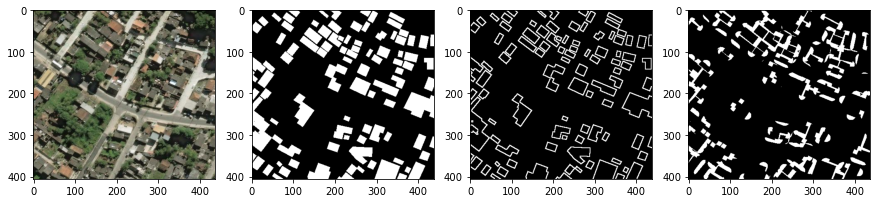

In [5]:
image_num=1200
sat_img = to_rgb(cv2.imread(f'{SATELLITE_IMAGES_PATH}/{image_num}.png'))
mask = to_rgb(cv2.imread(f'{MASKS_PATH}/{image_num}.png'))
print(np.unique(mask[:,:,0]))
print(np.unique(mask[:,:,1]))
print(np.unique(mask[:,:,2]))

fig, axes = plt.subplots(1,4,figsize=(15,15))
axes[0].imshow(sat_img)
axes[1].imshow(mask[:,:,0],cmap='gray')
axes[2].imshow(mask[:,:,1],cmap='gray')
axes[3].imshow(mask[:,:,2],cmap='gray')

### The dataset, augmentations, and dataloaders

In [6]:
# A `Dataset` should override `__len__` and `__getitem__`
class BuildingFootprintDataset(Dataset):
    def __init__(self, satellite_imgs_path:str=None, masks_path:str=None,satellite_file_names:List[str]=None, mask_file_names:List[str]=None, augmentation=None, preprocessing=None) -> None:
        super().__init__()
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        # can either specify the folder or a list of filenames
        # TODO: might not need the filenames option at all haha
        if satellite_imgs_path and masks_path:
            assert os.path.isdir(masks_path)
            assert os.path.isdir(satellite_imgs_path)
            self.satellite_imgs_path = satellite_imgs_path
            self.masks_path = masks_path 
            self.images = sorted(os.listdir(satellite_imgs_path), key=lambda x: int(x.split('.')[0]))
            self.images = [os.path.join(satellite_imgs_path, p) for p in self.images]
            self.image_masks = sorted(os.listdir(masks_path), key=lambda x: int(x.split('.')[0]))
            self.image_masks = [os.path.join(masks_path, p) for p in self.image_masks]
        if satellite_file_names and mask_file_names:
            self.images=satellite_file_names
            self.image_masks = mask_file_names
    def __len__(self):
        return len(self.image_masks)
    def __getitem__(self, index):
        image = to_rgb(cv2.imread(self.images[index]))
        mask = to_rgb(cv2.imread(self.image_masks[index]))
        # each channel is a seperate mask
        # masks = np.stack([mask[:,:,i] for i in range(mask.shape[-1])], axis=-1).astype('float')
        # just footprints
        masks = np.stack([mask[:,:,0]], axis=-1).astype('float')
        # masks=np.copy(mask)

        # apply augmentations
        if self.augmentation:
            # print(masks)
            sample = self.augmentation(image=image, mask=masks)
            image, masks = sample['image'],sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=masks)
            image, masks = sample['image'],sample['mask']
            
        return image, masks
        
    

4310


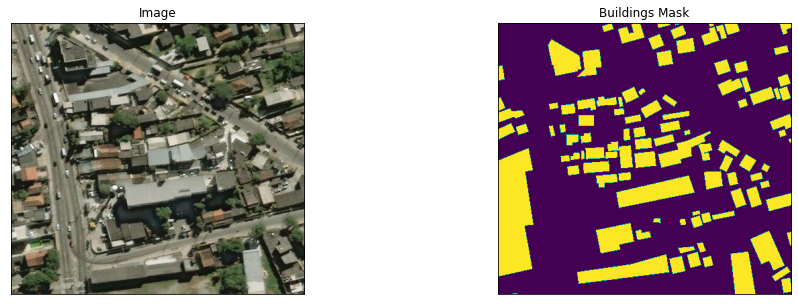

In [7]:
dataset = BuildingFootprintDataset(SATELLITE_IMAGES_PATH,MASKS_PATH)
print(len(dataset))
img, mask = dataset[1000]
visualize(
    image=img,
    buildings_mask=mask
)

Augmentations

In [8]:
def get_training_augmentation():
    train_transform = [
        # albu.Resize(IMG_SIZE[1],IMG_SIZE[0]),
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        ## need image height and width to be divisible by 32. this is a resnet network spec
        albu.PadIfNeeded(min_height=416, min_width=448, always_apply=True, border_mode=0),
        albu.RandomCrop(height=416, width=448, always_apply=True),

        albu.GaussNoise(p=0.2),
        albu.Perspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomBrightnessContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)

def get_validation_augmentation():
    test_transform = [
        albu.PadIfNeeded(min_height=416, min_width=448, always_apply=True, border_mode=0),
    ]
    return albu.Compose(test_transform)

def to_tensor(x, **kwargs):
    # makes from (w,h,channel) to (channel,w,h)
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

Trying it manually

(416, 448, 3)
(416, 448, 1)


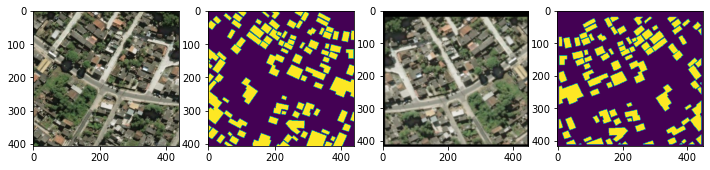

In [40]:
image_num=1200
sat_img = to_rgb(cv2.imread(f'{SATELLITE_IMAGES_PATH}/{image_num}.png'))
mask = np.expand_dims(to_rgb(cv2.imread(f'{MASKS_PATH}/{image_num}.png'))[:,:,0],axis=-1)

aug = get_training_augmentation()
sample = aug(image=sat_img,mask=mask)
augmented_img, augmented_mask = sample['image'], sample['mask']
print(augmented_img.shape)
print(augmented_mask.shape)
fig,axes=plt.subplots(1,4,figsize=(12,12))
axes[0].imshow(sat_img)
axes[1].imshow(mask)
axes[2].imshow(augmented_img)
axes[3].imshow(augmented_mask)

In [51]:
print(sat_img.shape)
print(sat_img.transpose(2,0,1).shape)
print(sat_img.transpose(2,0,1).transpose(1,2,0).shape)

(406, 438, 3)
(3, 406, 438)
(406, 438, 3)


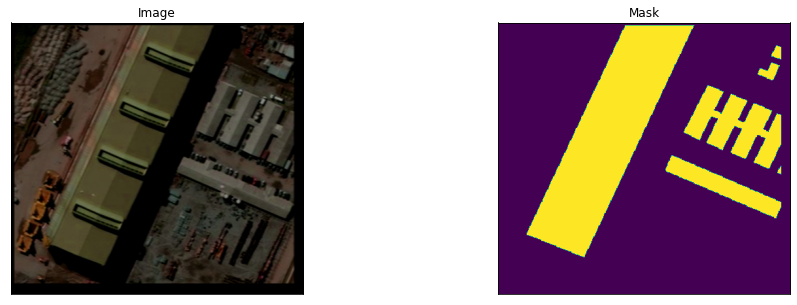

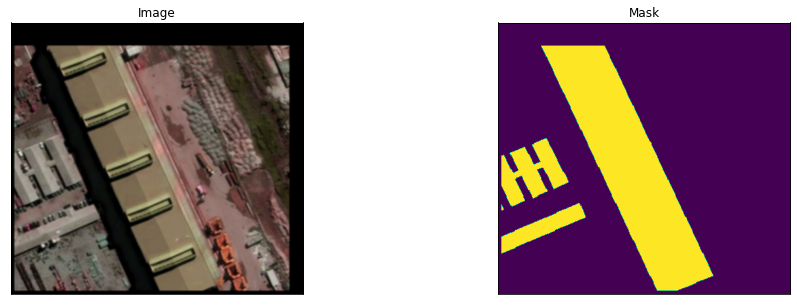

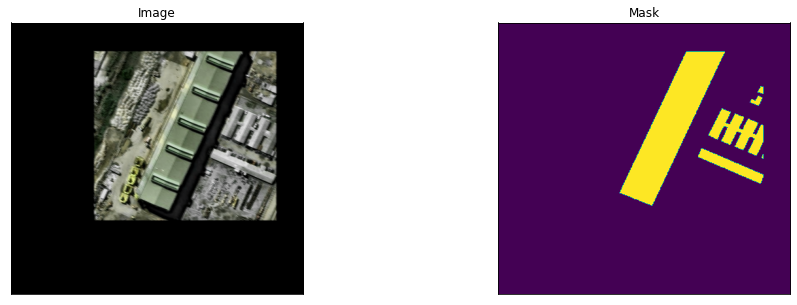

In [10]:
#### Visualize resulted augmented images and masks

augmented_dataset = BuildingFootprintDataset(
    SATELLITE_IMAGES_PATH, 
    MASKS_PATH, 
    augmentation=get_training_augmentation(), 
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[200]
    visualize(image=image, mask=mask)

In [11]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
# CLASSES=['footprint','boundary','contact']
CLASSES=['footprint']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'
# DEVICE = 'cpu'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = get_preprocessing_fn(ENCODER, pretrained=ENCODER_WEIGHTS)

In [ ]:
# no need to sort actually while listing the dir here. hmm
# satellite_img_files = [os.path.join(SATELLITE_IMAGES_PATH,f) for f in os.listdir(SATELLITE_IMAGES_PATH)]
# img_mask_files = [os.path.join(MASKS_PATH,f) for f in os.listdir(MASKS_PATH)]
# print(len(satellite_img_files))
# assert len(satellite_img_files)==len(img_mask_files)


In [12]:
dataset = BuildingFootprintDataset(
    SATELLITE_IMAGES_PATH, 
    MASKS_PATH, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

# train-validation split
test_len = len(augmented_dataset)//4
train_len = len(augmented_dataset) - test_len
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [train_len, test_len])

# sanity checks
i,m = train_dataset[0]
s=i.shape
print(s)
assert s[1]%32==0, s[2]%32==0
s=m.shape
print(s)
assert s[1]%32==0, s[2]%32==0


# prepare dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

(3, 416, 448)
(1, 416, 448)


### Training

In [13]:
## losses, metrics and optimizer
loss = smp_utils.losses.DiceLoss()
metrics = [
    smp_utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])


In [14]:
train_epoch = smp_utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)
valid_epoch = smp_utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [15]:
torch.cuda.is_available()

True

In [16]:

max_score = 0
# epochs
for i in range(0, 10):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './model/best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 1077/1077 [00:34<00:00, 31.18it/s, dice_loss - -0.7352, iou_score - 37.66]
Model saved!

Epoch: 1
valid: 100%|██████████| 1077/1077 [00:33<00:00, 31.95it/s, dice_loss - -0.7573, iou_score - 40.17]
Model saved!

Epoch: 2
valid: 100%|██████████| 1077/1077 [00:30<00:00, 35.28it/s, dice_loss - -0.7487, iou_score - 40.31]
Model saved!

Epoch: 3
valid: 100%|██████████| 1077/1077 [00:31<00:00, 34.69it/s, dice_loss - -0.7676, iou_score - 40.32]
Model saved!

Epoch: 4
valid: 100%|██████████| 1077/1077 [00:31<00:00, 34.73it/s, dice_loss - -0.7649, iou_score - 41.11]
Model saved!

Epoch: 5
valid: 100%|██████████| 1077/1077 [00:31<00:00, 34.50it/s, dice_loss - -0.7939, iou_score - 44.84]
Model saved!

Epoch: 6
valid: 100%|██████████| 1077/1077 [00:31<00:00, 34.26it/s, dice_loss - -0.7688, iou_score - 43.86]

Epoch: 7
valid: 100%|██████████| 1077/1077 [00:31<00:00, 34.18it/s, dice_loss - -0.7551, iou_score - 41.35]

Epoch: 8
valid: 100%|██████████| 1077/1077 [00:31

## Visualize best model outputs

In [17]:
sat_img = to_rgb(cv2.imread(f'{SATELLITE_IMAGES_PATH}/{image_num}.png'))
mask = to_rgb(cv2.imread(f'{MASKS_PATH}/{image_num}.png'))

In [18]:
best_model = torch.load('./model/best_model.pth',map_location='cpu')

In [34]:
test_dataset = BuildingFootprintDataset(
    SATELLITE_IMAGES_PATH, 
    MASKS_PATH, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn)
)
test_dataset_vis = BuildingFootprintDataset(
    SATELLITE_IMAGES_PATH, 
    MASKS_PATH, 
)

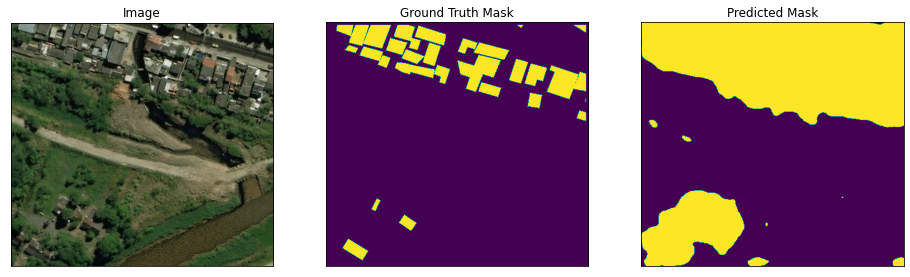

In [55]:
DEVICE='cpu'
for i in range(5):
    # n = np.random.choice(len(valid_dataset))
    n=300
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )
    break